Here we will provide code on how to recreate the plots for the cystic fibrosis results.

In [1]:
import os
import numpy as np
import pandas as pd
from biom import load_table
from skbio.stats.composition import clr, clr_inv, centralize, closure
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
data_dir = '../data/CF'

microbes = load_table(os.path.join(data_dir, 'otus_nt.biom')).to_dataframe().T
metabolites = load_table(os.path.join(data_dir, 'lcms_nt.biom')).to_dataframe().T

# align the samples
ids = set(microbes.index) & set(metabolites.index)
microbes = microbes.loc[ids]
metabolites = metabolites.loc[ids]

# to keep consistent with the mmvec analysis, microbes with less than 10 reads total are dropped
microbes = microbes.loc[:, (microbes>0).sum(axis=0) > 10]

In [3]:
from biom import Table
from biom.util import biom_open
microbe_table = Table(microbes.values.T, microbes.columns, microbes.index)
metabolite_table = Table(metabolites.values.T, metabolites.columns, metabolites.index)

with biom_open(data_dir + '/filtered_otus_nt.biom', 'w') as f:
    microbe_table.to_hdf5(f, 'matched')

with biom_open(data_dir + '/filtered_lcms_nt.biom', 'w') as f:
    metabolite_table.to_hdf5(f, 'matched')

In [4]:
microbes.shape, metabolites.shape

((172, 138), (172, 462))

Let's load the `ranks.csv` and the `omics-biplot.results` files that were created earlier. 
We'll also load the feature metadata mapping files, since we will use this information to paint the biplots.

In [5]:
data_dir = '../data/CF'
ranks = pd.read_csv('../results/cf_output/ranks.csv', index_col=0)
biplot_res = OrdinationResults.read('../results/cf_output/omics-biplot.results')

taxonomy = pd.read_table(os.path.join(data_dir, 'taxonomy.tsv'), index_col=0)
ms1_md = pd.read_table(os.path.join(data_dir, 'lcms_annotations.txt'), index_col=0)

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [6]:
biplot_res.samples.head()

,0,1,2
X290.0883mz60.1277,1.340645,-0.402680,-1.179627
X291.0489mz61.9903,-0.613122,1.815497,-0.103819
X254.1601mz62.7917,-0.268177,-0.136907,0.067728
X265.1154mz65.0188,-0.484228,0.463500,-0.356947
X118.0839mz71.5519,-0.190352,-0.317677,-0.301117


We'll want to do some preprocessing of the feature metadata to ease manipulation.  
Here, we'll just parse the taxonomies to make it easier to read.

In [7]:
taxa = pd.DataFrame(taxonomy.Taxon.apply(lambda x: x.split(';')).values.tolist(), 
                    index=taxonomy.index, 
                    columns=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'])

Cleaning up the metabolomics annotations is a little more tricky - we need to do two things

1. Match up the MS1 retention times and masses to the MS2 annotations
2. Clean up the chemical names.

I'm going to use a nearest neighbors approach regarding the retention times and masses.
The masses are expected to be more accurate (within +/- 1) whereas the retention times are expected to slip more (+/- 10).

We will need to extract the masses and retention ties from the ids.  Here the m/z is the first value and the retention time is the second value.

# WARNING!!!

As of now, there is no standardized protocol for labeling MS1 features.  Some MS1 bucket tables will be labeled with scan ids, or have the retention time and m/z flipped. So proceed with caution.

That can be done as follows

In [8]:
from scipy.spatial import KDTree

ms_ids = ranks.columns
mz = list(map(lambda x: float(x[1:].split('mz')[0]), ms_ids))
rt = list(map(lambda x: float(x[1:].split('mz')[1]), ms_ids))
df = pd.DataFrame({'measured_mz': mz, 'measured_rt': rt}, index=ms_ids)

We will create a database from the MS1 annotations, so that we will be matching the MS1 labels to the MS2 labels.
We will only be looking at the closest neighbor and we will be recording their distances and original retention time and m/z.

In [9]:
lookup = KDTree(ms1_md[['Precursor_MZ', 'RT_Query']])
d, i = lookup.query(df.values, k=1, eps=.1)

df['nearest_distance'] = d
df['scan'] = [ms1_md.index[k] for k in i]
df = df.reset_index()

Now we will merge the MS1 and MS2 annotations together.

In [10]:
ms1_md = ms1_md.reset_index()
ms_md = pd.merge(df, ms1_md, left_on='scan', right_on='#Scan#')
ms_md = ms_md.set_index('index')

Now that we have some sort of unified metabolite annotation metadata, we can now start digging into individual molecules.

Since P. aeruginosa is the best understood microbe in this system, we'll start by focusing on its known molecules, 
and merging that information into our metabolite annotations metadata.

In [11]:
data_dir = '../data/CF'
validation = pd.read_csv(
    os.path.join(data_dir, 'validated-molecules.csv'), 
    index_col=0, header=None
) 
validation.columns = ['rank', 'expert_annotation', 'shorthand']
ms_md = pd.merge(ms_md, validation, left_index=True, right_index=True, how='left')

Now we will want to start cleaning up some of the chemical names.  This is mainly for the
sake of visualization (since many of these names are just too darn long).

In [12]:
ms_md['shorthand'] = ms_md['shorthand'].fillna('None')

def annotation_f(x):
    if x['shorthand'] != 'None':
        return x['shorthand']
    if x['nearest_distance'] > 10 or len(x['Compound_Name']) > 30:
        return 'Other'
    if x['Compound_Name'] == 'Rha-Rha-C10-C10 (M+H)':
        return 'Rhamnolipid'
    if 'phosphocholine' in x['Compound_Name']:
        return 'Phosphocholine'
    if 'Palmitoylcarnitine' in x['Compound_Name']:
        return 'Palmitoylcarnitine'
    if 'phosphoethanolamine' in x['Compound_Name']:
        return 'Phosphoethanolamine'
    if 'butyrolactone' in x['Compound_Name']:
        return 'Butyrolactone'
    if 'indole' in x['Compound_Name'].lower():
        return 'indole'
    else:
        return x['Compound_Name']
    
ms_md['shorthand'] = ms_md.apply(annotation_f, axis=1)
ms_md.index.name = 'sampleid'

Before something else breaks, let's save all of the feature metadata files.
We can use these files for visualization later.

In [13]:
ms_md.to_csv('../results/cf_output/point-metadata.txt', sep='\t')

taxa.index.name = 'featureid'
taxa.to_csv('../results/cf_output/arrow-metadata.txt', sep='\t')

Now we will make a custom biplot -- it is going to be hairy, so take a deep breath.

In [14]:
idx = (taxa['genus'] == ' g__Veillonella') | (taxa['genus'] == ' g__Fusobacterium') | (taxa['genus'] == " g__Prevotella")
anaerobe_seqs = taxa.loc[idx].index

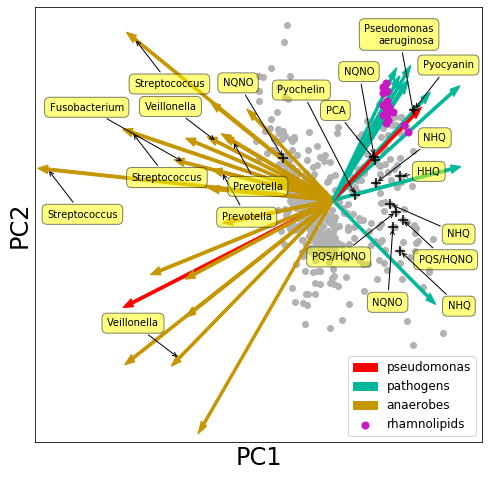

In [15]:
from scipy.spatial.distance import euclidean
 
# only plot the top 30 features
features = biplot_res.features
features['importance'] = features.apply(lambda x: euclidean(np.zeros_like(x), x), axis=1)
features.sort_values('importance', inplace=True, ascending=False)
features.drop(['importance'], inplace=True, axis=1)
biplot_res.features = features[:30]

p_aeruginosa = taxa.loc[(taxa['genus'] == ' g__Pseudomonas').values].index[0]

# Now actually make the biplot
fig = plt.figure(figsize=(8, 8))

ridx = ms_md.loc[ms_md.shorthand == 'Rhamnolipid'].index
idx = ms_md.loc[ms_md.shorthand != 'Rhamnolipid'].index

rhamolipid_color = '#C918C1'
other_color = '#B2B2B2'
pseudomonas_color = 'r'
fermenter_color = '#00B899'
anaerobe_color = '#C69600'

arrow_width = .03
other = plt.scatter(biplot_res.samples.loc[idx, 0], 
                    biplot_res.samples.loc[idx, 1], 
                    color=other_color, label='other')
for i in biplot_res.features.index:
    label = taxa.loc[i, 'genus']    
    if label == ' g__Pseudomonas':
        pseudomonas = plt.arrow(
            0, 0, biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], 
            color=pseudomonas_color, width=arrow_width)        
         
    elif biplot_res.features.loc[i, 0] > 0:        
        pathogens = plt.arrow(
            0, 0, biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], 
            color=fermenter_color, width=arrow_width)
    else:
        anaerobes = plt.arrow(
            0, 0, biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], 
            color=anaerobe_color, width=arrow_width)       
        
    
    if i == p_aeruginosa:
        plt.annotate(
            "Pseudomonas\naeruginosa",
            xy=(biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], ), 
            xytext=(20, 70),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))   
        
    elif label == ' g__Veillonella':
        plt.annotate(
            "Veillonella",
            xy=(biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], ), 
            xytext=(-20, 30),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    elif label == ' g__Fusobacterium':
        plt.annotate(
            "Fusobacterium",
            xy=(biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], ), 
            xytext=(-60, 50),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))           
    elif label == ' g__Prevotella':
        plt.annotate(
            "Prevotella",
            xy=(biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], ), 
            xytext=(50, -50),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))            
    elif label == ' g__Streptococcus':
        plt.annotate(
            "Streptococcus",
            xy=(biplot_res.features.loc[i, 0], biplot_res.features.loc[i, 1], ), 
            xytext=(70, -50),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))            
rhamnolipids = plt.scatter(biplot_res.samples.loc[ridx, 0], 
                           biplot_res.samples.loc[ridx, 1], s=50,
                           color=rhamolipid_color, zorder=5, label='Rhamnolipid')

compounds = pd.DataFrame({
    'X211.0918mz161.2083': ['Pyocyanin', 60, 40],
    'X325.0673mz300.6387': ['Pyochelin', -30, 100],
    'X232.1329mz284.2357': ['PCA', -30, 45],
    'X244.1681mz317.3049': ['HHQ', 40, 0],
    'X258.1804mz348.1582': ['PQS/HQNO', 70, -45],
    'X256.1688mz350.8455': ['PQS/HQNO', -30, -50],
    'X273.2005mz375.3707': ['NHQ', 70, -60],
    'X271.1934mz377.8070': ['NHQ', 80, -35],
    'X272.2311mz381.5715': ['NHQ', 70, 40],
    'X289.2395mz367.6799': ['NQNO', 0, 80],
    'X295.1511mz367.9210': ['NQNO', -30, 70],
    'X284.1965mz373.1668': ['NQNO', 10, -80]
}, ['compound', 'dx', 'dy']).T

#compounds = [
#    'Pyochelin', 'Phenazine-1-carboxylic Acid', 
#    'HHQ', 'NHQ', 'C9:db-PQS, C9:DB-NQNO', 
#    'PQS/HQNO', 'Pyocyanin'
#]

subsamples = pd.merge(compounds, biplot_res.samples, left_index=True, right_index=True)
#compound_idx = [ms_md.loc[c, 'shorthand'] in compounds for c in ms_md.index]
#compound_idx = ms_md.loc[compound_idx].index
#subsamples = biplot_res.samples.loc[compound_idx]
plt.scatter(subsamples[0], subsamples[1], marker='+',
            color='k', s=100, zorder=10)

for i in subsamples.index:
    x, y = subsamples.loc[i, 0], subsamples.loc[i, 1]
    dx, dy = subsamples.loc[i, 'dx'], subsamples.loc[i, 'dy']
    #label = ms_md.loc[i, 'shorthand']
    label = subsamples.loc[i, 'compound']
    plt.annotate(
        label,
        xy=(x, y), xytext=(dx, dy),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.legend([pseudomonas, pathogens, anaerobes, rhamnolipids], 
           ['pseudomonas', 'pathogens', 'anaerobes', 'rhamnolipids'], 
           fontsize=12, loc=4)

#plt.legend()
plt.xlim([-4, 2])
plt.ylim([-2.5, 2])
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.savefig('../results/cf_output/biplot.png')

Now we'll try to interpret the principal components underlying the above plot. 

First, we'll reload the ordination results object, along with the differentials learned from multinomial regression.
Note, the differentials quantify how much the microbe/metabolite abundances have changed with respect to the
oxygen gradient.

In [16]:
!ls ../results/cf_output/filtered_otus_nt.biom_prior0.5_songbird_results

summary_filtered_otus_nt.biom_dim_prior0.5_lr_beta1_beta2_sub_batch5_id_depth


In [17]:
results_dir = '../results/cf_output/'

otudir = ('filtered_otus_nt.biom_prior5_songbird_results/'
          'summary_filtered_otus_nt.biom_dim_prior5_lr_beta1_beta2_sub_batch5_depth')
otudiffs = pd.read_table(os.path.join(os.path.join(results_dir, otudir), 'differentials.tsv'), index_col=0)

msdir = ('filtered_lcms_nt.biom_prior5_songbird_results/'
         'summary_filtered_lcms_nt.biom_dim_prior5_lr_beta1_beta2_sub_batch5_depth')
msdiffs = pd.read_table(os.path.join(os.path.join(results_dir, msdir), 'differentials.tsv'), index_col=0)

biplot_res = OrdinationResults.read('../results/cf_output/omics-biplot.results')

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


First, let's visualize the relationship between PC1 above and the oxygen differential.  
Note that the units of the oxygen are in terms of log fold change with regards to the depth within a sample.  
Because of compositional properties of the data, we cannot exactly infer the log-fold change. 
However, we can estimate the log-fold change up to a constant bias, which means that the intercept below maybe off, but the slope should be legitimate.

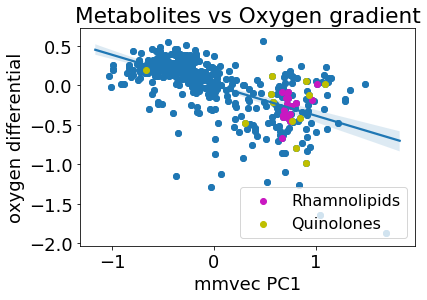

In [18]:
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

idx = list(set(biplot_res.samples.index) & set(msdiffs.index))
#plt.scatter(biplot_res.samples[0].loc[idx], msdiffs.depth.loc[idx])

ms_res = pd.DataFrame({'mmvec PC1': biplot_res.samples[0].loc[idx], 
                       'oxygen differential':msdiffs.depth.loc[idx]})

sns.regplot(x='mmvec PC1', y='oxygen differential', data=ms_res, n_boot=1000)
plt.scatter(biplot_res.samples[0].loc[idx], msdiffs.depth.loc[idx])
plt.scatter(biplot_res.samples[0].loc[ridx], msdiffs.depth.loc[ridx], 
            c=rhamolipid_color, label='Rhamnolipids')
plt.scatter(biplot_res.samples[0].loc[compounds.index], msdiffs.depth.loc[compounds.index], 
            c='y', label='Quinolones')

plt.title('Metabolites vs Oxygen gradient')
plt.legend(loc=4, fontsize=16)

In [19]:
from scipy.stats import pearsonr
pearsonr(biplot_res.samples[0].loc[idx], msdiffs.depth.loc[idx])

(-0.5994279332439486, 1.8300776556582407e-44)

Here, we will plot the learned log-fold change of the microbes with respect the oxygen gradient.

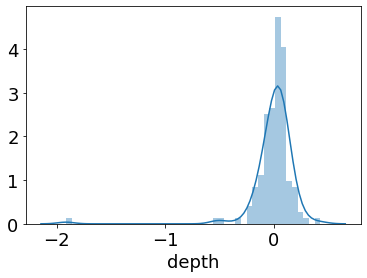

In [20]:
import seaborn as sns
sns.distplot(otudiffs.depth)

Text(0, 0.5, 'Depth differential')

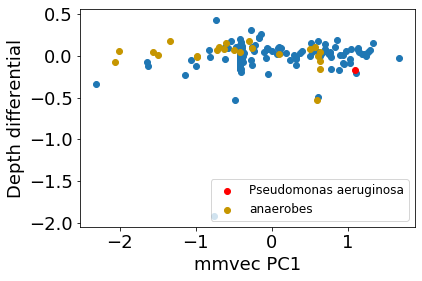

In [21]:
idx = list(set(biplot_res.features.index) & set(otudiffs.index))
plt.scatter(biplot_res.features[1].loc[idx], otudiffs.depth.loc[idx])

otu_res = pd.DataFrame({'mmvec PC1': biplot_res.features[0].loc[idx], 
                        'depth differential': otudiffs.depth.loc[idx]})

#sns.regplot(x='mmvec PC1', y='depth differential', data=otu_res, n_boot=1000)
anaerobe_taxa = set(anaerobe_seqs) & set(biplot_res.features.index)
plt.scatter(biplot_res.features[0].loc[p_aeruginosa],
            otudiffs.depth.loc[p_aeruginosa], c=pseudomonas_color, label='Pseudomonas aeruginosa')
plt.scatter(biplot_res.features[0].loc[anaerobe_taxa],
            otudiffs.depth.loc[anaerobe_taxa], c=anaerobe_color, label='anaerobes')
plt.legend(loc=4, fontsize=12)
plt.xlabel('mmvec PC1')
plt.ylabel('Depth differential')

In [22]:
pearsonr(biplot_res.features[0].loc[idx], otudiffs.depth.loc[idx])

(0.11810216865892013, 0.16770981364002324)

Turns out there isn't much change, only two microbe stick out.  One of them is a mitochondria that was referenced in the original paper.

Now, we will focus on only the most abundant microbes on opposite ends of PC1.

In [23]:
top_taxa = microbes.apply(np.argmax, axis=1).value_counts().index
taxa_max_counts = microbes.apply(np.argmax, axis=1).value_counts()
streptococcus = biplot_res.features.loc[top_taxa, 0].argmin()

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Number of maximal samples')

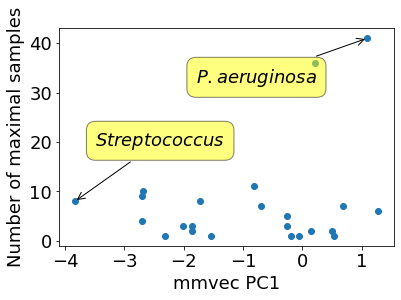

In [24]:
plt.scatter(biplot_res.features.loc[top_taxa, 0],
            microbes.apply(np.argmax, axis=1).value_counts())

plt.annotate(
    "$P. aeruginosa$",
    xy=(biplot_res.features.loc[p_aeruginosa, 0], taxa_max_counts.loc[p_aeruginosa]), 
    xytext=(-50, -50),
    textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))      

plt.annotate(
    "$Streptococcus$",
    xy=(biplot_res.features.loc[streptococcus, 0], taxa_max_counts.loc[streptococcus]), 
    xytext=(150, 50),
    textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))   

plt.xlabel('mmvec PC1')
plt.ylabel('Number of maximal samples')

In [25]:
top_df = pd.DataFrame({i: microbes.apply(np.argmax, axis=1) == i 
                       for i in top_taxa}, index=microbes.index)
top_df = top_df.sort_values(by=list(top_taxa), ascending=False)
samples = top_df.index

Let's visualize the predicted molecule abundances in the samples where P. aeruginosa is the most abundant.

Text(0.5, 1.0, 'Pseudomonas metabolite \n abundance prediction')

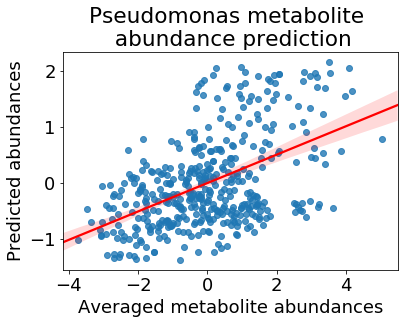

In [26]:
pred = np.exp(ranks.loc[top_taxa[0]])
pred = pred / pred.sum()
actual = metabolites.loc[top_df[top_taxa[0]]].sum(axis=0)
actual = actual / actual.sum()

res = pd.DataFrame({'actual': actual, 'pred': pred})
res = res.loc[res.actual > 0]
res['Averaged metabolite abundances'] = clr(res.actual)
res['Predicted abundances'] = clr(res.pred)

sns.regplot('Averaged metabolite abundances', 
            'Predicted abundances', res, line_kws={'color': 'r'})
plt.title('Pseudomonas metabolite \n abundance prediction')

In [27]:
pearsonr(res.actual, res.pred)

(0.3197561946766698, 1.1816114209919019e-11)

In [28]:
0.3197561946766698**2

0.10224402403410437

Now, let's try a heatmap of the molecular abundances of the two microbes that were selected.

Text(0.5, 1, 'Metabolite abundances')

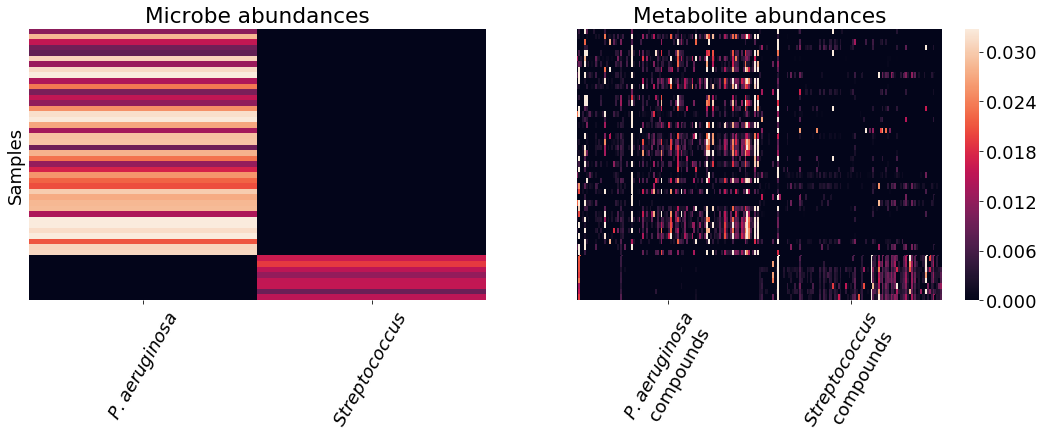

In [29]:
top_ms_samples = pd.concat((
    metabolites.loc[top_df[top_taxa[0]]],
    metabolites.loc[top_df[top_taxa[2]]]
), axis=0)

p_aeruginosa_top = ranks.loc[top_taxa[0]].sort_values().index[-100:]
streptococcus_top = ranks.loc[streptococcus].sort_values().index[-100:]
p_aeruginosa_samples = microbes.apply(np.argmax, axis=1) == top_taxa[0]
p_aeruginosa_samples = microbes.index[p_aeruginosa_samples.values]
streptococcus_samples = microbes.apply(np.argmax, axis=1) == streptococcus
streptococcus_samples = microbes.index[streptococcus_samples.values]

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
cmicrobes = microbes.apply(lambda x: x / x.sum(), axis=1)
sns.heatmap(cmicrobes.loc[list(p_aeruginosa_samples) + list(streptococcus_samples),
                          [top_taxa[0], streptococcus]].values, 
            robust=True, ax=ax[0], cbar=False)
ax[0].set_xticklabels(['$P. aeruginosa$', '$Streptococcus$'], rotation=60)
ax[0].set_yticks([])
ax[0].set_ylabel('Samples')
ax[0].set_title('Microbe abundances')

cmetabolites = metabolites.apply(lambda x: x / x.sum(), axis=1)
sns.heatmap(cmetabolites.loc[list(p_aeruginosa_samples) + list(streptococcus_samples), 
                             list(p_aeruginosa_top) + list(streptococcus_top)].values, 
            robust=True, ax=ax[1])
ax[1].set_yticks([])
ax[1].set_xticks([50, 150])
ax[1].set_xticklabels(['$P. aeruginosa$\n compounds', 
                       '$Streptococcus$ \n compounds'], rotation=60)
ax[1].set_title('Metabolite abundances')
#plt.tight_layout()

Here we will perform a log ratio test to quantify the differences in those microbes.  Only the top 100 P. aeruginosa molecules and top 100 Streptococcus associated molecules are displayed.

In [30]:
from scipy.stats import ttest_ind
lr = np.log(cmetabolites[list(p_aeruginosa_top)].sum(axis=1) / cmetabolites[list(streptococcus_top)].sum(axis=1))
ttest_ind(lr.loc[list(p_aeruginosa_samples)], lr.loc[list(streptococcus_samples)])

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Ttest_indResult(statistic=6.514280643585684, pvalue=4.4659227310077394e-08)

Another thing worth doing is to compare and contrast the P. aeruginosa results between the conditional probabilities and the Pearson correlations.

Let's retrieve the original microbe/metabolite data and match their samples.

In [31]:
data_dir = '../data/CF/'

microbes = load_table(os.path.join(data_dir, 'otus_nt.biom')).to_dataframe().T
metabolites = load_table(os.path.join(data_dir, 'lcms_nt.biom')).to_dataframe().T

# cast to dense dataframes and normalize to 1
microbes = pd.DataFrame(microbes).apply(lambda x: x / x.sum(), axis=1)
metabolites = pd.DataFrame(metabolites).apply(lambda x: x / x.sum(), axis=1)


# align the samples
ids = set(microbes.index) & set(metabolites.index)
microbes = microbes.loc[ids]
metabolites = metabolites.loc[ids]

# to keep consistent with the minstrel analysis, microbes with less than 10 reads total are dropped
microbes = microbes.loc[:, (microbes>0).sum(axis=0) > 10]

Let's calculate the Pearson correlation coefficients.

In [32]:
from scipy.stats import spearmanr, pearsonr

# extract the P. aeroginosa deblurred sequence
pseudomonas = taxa.loc[(taxa['genus'] == ' g__Pseudomonas').values].index[0]

# extract the P. aeroginosa ranks / probabilities.
pranks = ranks.loc[pseudomonas].sort_values()

pear_ranks = pd.Series(index=ms_md.index)
pear_pvals = pd.Series(index=ms_md.index)
pranks = pranks.loc[pear_ranks.index]

for i in ms_ids:
    r = pearsonr(list(microbes[pseudomonas].values), list(metabolites[i].values))
    pear_ranks.loc[i] = r[0]
    pear_pvals.loc[i] = r[1]    

The comparison between the Pearson and Conditional probabilities is given below.
The conditional probabilities here are log transformed and centered around the mean log.

The dots are all sized by the -log pvalue from Pearson correlation.

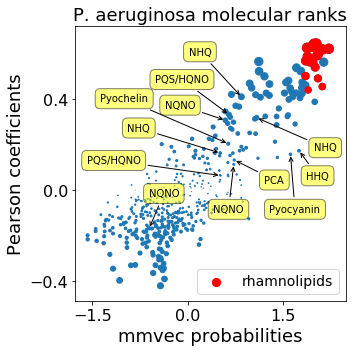

In [33]:
matplotlib.rcParams.update({'font.size': 10})


fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pranks, pear_ranks, s=-2*np.log(pear_pvals))
ax.scatter(pranks.loc[ridx], pear_ranks.loc[ridx], color='r', 
            s=-2*np.log(pear_pvals.loc[ridx]), label='rhamnolipids')
ax.set_xlabel('mmvec probabilities', fontsize=18)
ax.set_ylabel('Pearson coefficients', fontsize=18)
ax.set_title('P. aeruginosa molecular ranks', fontsize=18)
ax.legend(loc=4, fontsize=14)

compounds = pd.DataFrame({
    'X211.0918mz161.2083': ['Pyocyanin', 30, -60],
    'X325.0673mz300.6387': ['Pyochelin', -80, 40],
    'X232.1329mz284.2357': ['PCA', 50, -25],
    'X244.1681mz317.3049': ['HHQ', 30, -30],
    'X258.1804mz348.1582': ['PQS/HQNO', -80, 10],
    'X256.1688mz350.8455': ['PQS/HQNO', -20, 30],
    'X273.2005mz375.3707': ['NHQ', -70, 20],
    'X271.1934mz377.8070': ['NHQ', 80, -35],
    'X272.2311mz381.5715': ['NHQ', -30, 40],
    'X289.2395mz367.6799': ['NQNO', 10, -50],
    'X295.1511mz367.9210': ['NQNO', 30, 30],
    'X284.1965mz373.1668': ['NQNO', -30, 10]
}, ['compound', 'dx', 'dy']).T

subsamples = pd.merge(biplot_res.samples, compounds, left_index=True, right_index=True)

for i in subsamples.index:
    x, y = pranks.loc[i], pear_ranks.loc[i]
    dx, dy = subsamples.loc[i, 'dx'], subsamples.loc[i, 'dy']
    
    label = subsamples.loc[i, 'compound']
    #dx = np.sign(x)*50
    #dy = np.sign(y)*50
    ax.annotate(
        label,
        xy=(x, y), xytext=(dx, dy),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()

We can zoom in on the Rhamnolipids to see how the ranks compare

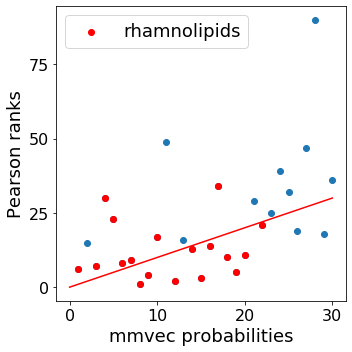

In [34]:
from scipy.stats import rankdata
fig, ax = plt.subplots(figsize=(5, 5))

conditional_ranks = pd.Series(rankdata(-pranks), pranks.index)
pearson_ranks = pd.Series(rankdata(-pear_ranks), pear_ranks.index)
k = conditional_ranks.sort_values().iloc[:30].index

ax.scatter(list(conditional_ranks.loc[k].values),
           list(pearson_ranks.loc[k].values))
ax.scatter(list(conditional_ranks.loc[ridx].values),
           list(pearson_ranks.loc[ridx].values), 
           label='rhamnolipids', c='r')
ax.plot(np.linspace(0,30), np.linspace(0,30), c='r')
ax.set_xlabel('mmvec probabilities', fontsize=18)
ax.set_ylabel('Pearson ranks', fontsize=18)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))

plt.legend(fontsize=18)
plt.tight_layout()

Below are some stats for Pearson correlation

In [35]:
from statsmodels.stats.multitest import multipletests
corrected_pearson_pvals = pd.Series((multipletests(pear_pvals, method='fdr_bh')[1]), 
                                     index=pear_pvals.index)

In [36]:
from statsmodels.stats.multitest import multipletests

# annotated compounds known to be produced by Pseudomonas
compounds = [
    'Pyochelin', 'Phenazine-1-carboxylic Acid', 
    'HHQ', 'NHQ', 'C9:db-PQS, C9:DB-NQNO', 
    'PQS/HQNO', 'Pyocyanin'
]
compound_idx = [ms_md.loc[c, 'shorthand'] in compounds for c in ms_md.index]

print('Total detected with Pearson with FDR correction', 
      multipletests(pear_pvals, method='fdr_bh')[0].sum())

print('Annotated compounds detected with Pearson without FDR correction', 
      (pear_pvals[compound_idx] < 0.05).sum())

print('Annotated compounds detected with Pearson with FDR correction', 
      (multipletests(pear_pvals, method='fdr_bh')[0][compound_idx]).sum())

print('Number of Rhamnolipids detected by Pearson without FDR correction', 
      (pear_pvals[ridx] < 0.05).sum())

print('Number of Rhamnolipids detected by Pearson with FDR correction', 
      pd.Series((multipletests(pear_pvals, method='fdr_bh')[0]), 
                index=pear_pvals.index).loc[ridx].sum())

Total detected with Pearson with FDR correction 159
Annotated compounds detected with Pearson without FDR correction 9
Annotated compounds detected with Pearson with FDR correction 5
Number of Rhamnolipids detected by Pearson without FDR correction 18
Number of Rhamnolipids detected by Pearson with FDR correction 18


To look in more detail about the specific correlations, we can look at the P. aeruginosa abundance vs Pyocyanin (which was quite different between the two)

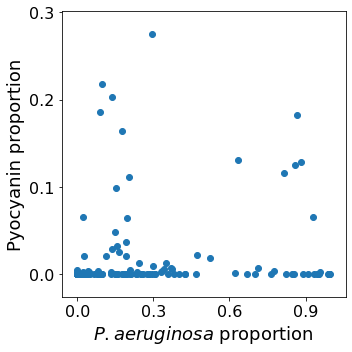

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
j = 'X211.0918mz161.2083' # pyocyanin
ax.scatter(list(microbes[pseudomonas].values),
            list(metabolites[j].values))
ax.set_xlabel(r'$\it{P. aeruginosa}$ proportion', fontsize=18)
ax.set_ylabel('Pyocyanin proportion', fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()

In [38]:
pear_ranks.loc['X211.0918mz161.2083'], pear_pvals.loc['X211.0918mz161.2083'], corrected_pearson_pvals.loc['X211.0918mz161.2083']

(0.1571569777419644, 0.03950602519558265, 0.08991026423822258)

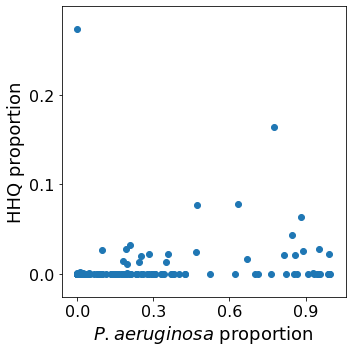

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
j = 'X244.1681mz317.3049' # pyocyanin
ax.scatter(list(microbes[pseudomonas].values),
            list(metabolites[j].values))
ax.set_xlabel(r'$\it{P. aeruginosa}$ proportion', fontsize=18)
ax.set_ylabel('HHQ proportion', fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()

In [40]:
pear_ranks.loc['X244.1681mz317.3049'], pear_pvals.loc['X244.1681mz317.3049'], corrected_pearson_pvals.loc['X244.1681mz317.3049']

(0.1726421446086391, 0.02353092061463475, 0.06176866661341622)